# Group Chat

Group chat is a design pattern where a group of agents share a common thread
of messages: they all subscribe and publish to the same topic. 
Each participant agent is specialized for a particular task, 
such as writer, illustrator, and editor
in a collaborative writing task.
You can also include an agent to represent a human user to help guide the
agents when needed.

In a group chat, participants take turn to publish a message, and the process
is sequential -- only one agent is working at a time.
Under the hood, the order of turns is maintained by a Group Chat Manager agent,
which selects the next agent to speak upon receving a message.
The exact algorithm for selecting the next agent can vary based on your
application requirements. 
Typically, a round-robin algorithm or a selector with an LLM model is used.

Group chat is useful for dynamically decomposing a complex task into smaller ones 
that can be handled by specialized agents with well-defined roles.
It is also possible to nest group chats into a hierarchy with each participant
a recursive group chat.

In this example, we use AutoGen's Core API to implement the group chat pattern
using event-driven agents.
Please first read about [Topics and Subscriptions](../core-concepts/topic-and-subscription.md)
to understand the concepts and then [Messages and Communication](../framework/message-and-communication.ipynb)
to learn the API usage for pub-sub.
We will demonstrate a simple example of a group chat with a LLM-based selector
for the group chat manager, to create content for a children's story book.

```{note}
While this example illustrates the group chat mechanism, it is complex and
represents a starting point from which you can build your own group chat system
with custom agents and speaker selection algorithms.
The [AgentChat API](../../agentchat-user-guide/index.md) has a built-in implementation
of selector group chat. You can use that if you do not want to use the Core API.
```

We will be using the [rich](https://github.com/Textualize/rich) library to display the messages in a nice format.

In [1]:
# ! pip install rich

In [2]:
import json
import string
import uuid
from typing import List

import openai
from autogen_core import (
    DefaultTopicId,
    FunctionCall,
    Image,
    MessageContext,
    RoutedAgent,
    SingleThreadedAgentRuntime,
    TopicId,
    TypeSubscription,
    message_handler,
)
from autogen_core.components.tools import FunctionTool
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)
from autogen_ext.models import OpenAIChatCompletionClient
from IPython.display import display  # type: ignore
from pydantic import BaseModel
from rich.console import Console
from rich.markdown import Markdown

## Message Protocol

The message protocol for the group chat pattern is simple.
1. To start, user or an external agent publishes a `GroupChatMessage` message to the common topic of all participants.
2. The group chat manager selects the next speaker, sends out a `RequestToSpeak` message to that agent.
3. The agent publishes a `GroupChatMessage` message to the common topic upon receiving the `RequestToSpeak` message.
4. This process continues until a termination condition is reached at the group chat manager, which then stops issuing `RequestToSpeak` message, and the group chat ends.

The following diagram illustrates steps 2 to 4 above.

![Group chat message protocol](groupchat.svg)

In [3]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass

## Base Group Chat Agent

Let's first define the agent class that only uses LLM models to generate text.
This is will be used as the base class for all AI agents in the group chat.

In [4]:
class BaseGroupChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(content=system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.extend(
            [
                UserMessage(content=f"Transferred to {message.body.source}", source="system"),
                message.body,
            ]
        )

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        completion = await self._model_client.create([self._system_message] + self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        Console().print(Markdown(completion.content))
        # print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )

## Writer and Editor Agents

Using the base class, we can define the writer and editor agents with
different system messages.

In [5]:
class WriterAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are a Writer. You produce good work.",
        )


class EditorAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Editor. Plan and guide the task given by the user. Provide critical feedbacks to the draft and illustration produced by Writer and Illustrator. "
            "Approve if the task is completed and the draft and illustration meets user's requirements.",
        )

## Illustrator Agent with Image Generation

Now let's define the `IllustratorAgent` which uses a DALL-E model to generate
an illustration based on the description provided.
We set up the image generator as a tool using {py:class}`~autogen_core.components.tools.FunctionTool`
wrapper, and use a model client to make the tool call.

In [6]:
class IllustratorAgent(BaseGroupChatAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Illustrator. You use the generate_image tool to create images given user's requirement. "
            "Make sure the images have consistent characters and style.",
        )
        self._image_client = image_client
        self._image_gen_tool = FunctionTool(
            self._image_gen, name="generate_image", description="Call this to generate an image. "
        )

    async def _image_gen(
        self, character_appearence: str, style_attributes: str, worn_and_carried: str, scenario: str
    ) -> str:
        prompt = f"Digital painting of a {character_appearence} character with {style_attributes}. Wearing {worn_and_carried}, {scenario}."
        response = await self._image_client.images.generate(
            prompt=prompt, model="dall-e-3", response_format="b64_json", size="1024x1024"
        )
        return response.data[0].b64_json  # type: ignore

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:  # type: ignore
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history,
            tools=[self._image_gen_tool],
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            Console().print(arguments)
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            image = Image.from_pil(image.image.resize((256, 256)))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

## User Agent

With all the AI agents defined, we can now define the user agent that will
take the role of the human user in the group chat.

The `UserAgent` implementation uses console input to get the user's input.
In a real-world scenario, you can replace this by communicating with a frontend,
and subscribe to responses from the frontend.

In [7]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, group_chat_topic_type: str) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        # When integrating with a frontend, this is where group chat message would be sent to the frontend.
        pass

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        user_input = input("Enter your message, type 'APPROVE' to conclude the task: ")
        Console().print(Markdown(f"### User: \n{user_input}"))
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=user_input, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

## Group Chat Manager

Lastly, we define the `GroupChatManager` agent which manages the group chat
and selects the next agent to speak using an LLM.
The group chat manager checks if the editor has approved the draft by 
looking for the `"APPORVED"` keyword in the message. If the editor has approved
the draft, the group chat manager stops selecting the next speaker, and the group chat ends.

The group chat manager's constructor takes a list of participants' topic types
as an argument.
To prompt the next speaker to work, 
the it publishes a `RequestToSpeak` message to the next participant's topic.

In this example, we also make sure the group chat manager always picks a different
participant to speak next, by keeping track of the previous speaker.
This helps to ensure the group chat is not dominated by a single participant.

In [8]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type: str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the user, stop the chat.
        if message.body.source == "User":
            assert isinstance(message.body.content, str)
            if message.body.content.lower().strip(string.punctuation).endswith("approve"):
                return
        # Format message history.
        messages: List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line: List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            content=selector_prompt.format(
                roles=roles,
                history=history,
                participants=str(
                    [
                        topic_type
                        for topic_type in self._participant_topic_types
                        if topic_type != self._previous_participant_topic_type
                    ]
                ),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")

## Creating the Group Chat

To set up the group chat, we create an {py:class}`~autogen_core.SingleThreadedAgentRuntime`
and register the agents' factories and subscriptions.

Each participant agent subscribes to both the group chat topic as well as its own
topic in order to receive `RequestToSpeak` messages, 
while the group chat manager agent only subcribes to the group chat topic.

In [9]:
runtime = SingleThreadedAgentRuntime()

editor_topic_type = "Editor"
writer_topic_type = "Writer"
illustrator_topic_type = "Illustrator"
user_topic_type = "User"
group_chat_topic_type = "group_chat"

editor_description = "Editor for planning and reviewing the content."
writer_description = "Writer for creating any text content."
user_description = "User for providing final approval."
illustrator_description = "An illustrator for creating images."

editor_agent_type = await EditorAgent.register(
    runtime,
    editor_topic_type,  # Using topic type as the agent type.
    lambda: EditorAgent(
        description=editor_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=editor_topic_type, agent_type=editor_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=editor_agent_type.type))

writer_agent_type = await WriterAgent.register(
    runtime,
    writer_topic_type,  # Using topic type as the agent type.
    lambda: WriterAgent(
        description=writer_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=writer_topic_type, agent_type=writer_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=writer_agent_type.type))

illustrator_agent_type = await IllustratorAgent.register(
    runtime,
    illustrator_topic_type,
    lambda: IllustratorAgent(
        description=illustrator_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        image_client=openai.AsyncClient(
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=illustrator_topic_type, agent_type=illustrator_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=illustrator_agent_type.type)
)

user_agent_type = await UserAgent.register(
    runtime,
    user_topic_type,
    lambda: UserAgent(description=user_description, group_chat_topic_type=group_chat_topic_type),
)
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=user_agent_type.type))

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[writer_topic_type, illustrator_topic_type, editor_topic_type, user_topic_type],
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        participant_descriptions=[writer_description, illustrator_description, editor_description, user_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)

## Running the Group Chat

We start the runtime and publish a `GroupChatMessage` for the task to start the group chat.

Writer:

Title: The Escape of the Gingerbread Man                                                                           

Illustration 1: A Rustic Kitchen Scene In a quaint little cottage at the edge of an enchanted forest, an elderly   
woman, with flour-dusted hands, carefully shapes gingerbread dough on a wooden counter. The aroma of ginger,       
cinnamon, and cloves wafts through the air as a warm breeze from the open window dances with fluttering curtains.  
The sunlight gently permeates the cozy kitchen, casting a golden hue over the flour-dusted surfaces and the rolling
pin. Heartfelt trinkets and rustic decorations adorn the shelves - signs of a lived-in, lovingly nurtured home.    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Story:                                                                                                             

Once there was an old woman who lived alone in a charming cottage, her days filled with the joyful art of baking.  
One sunny afternoon, she decided to make a special gingerbread man to keep her company. As she shaped him tenderly 
and placed him in the oven, she couldn't help but smile at the delight he might bring.                             

But to her astonishment, once she opened the oven door to check on her creation, the gingerbread man leapt out,    
suddenly alive. His eyes were bright as beads, and his smile cheeky and wide. "Run, run, as fast as you can! You   
can't catch me, I'm the Gingerbread Man!" he laughed, darting towards the door.                                    

The old woman, chuckling at the unexpected mischief, gave chase, but her footsteps were slow with the weight of    
age. The Gingerbread Man raced out of the door and into the sunny afternoon.                                       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 2: A Frolic Through the Meadow The Gingerbread Man darts through a vibrant meadow, his arms swinging  
joyously by his sides. Behind him trails the old woman, her apron flapping in the wind as she gently tries to catch
up. Wildflowers of every color bloom vividly under the radiant sky, painting the scene with shades of nature's     
brilliance. Birds flit through the sky and a stream babbles nearby, oblivious to the chase taking place below.     

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Continuing his sprint, the Gingerbread Man encountered a cow grazing peacefully. Intrigued, the cow trotted        
forward. "Stop, Gingerbread Man! I wish to eat you!" she called, but the Gingerbread Man only twirled in a teasing 
jig, flashing his icing smile before darting off again.                                                            

"Run, run, as fast as you can! You can't catch me, I'm the Gingerbread Man!" he taunted, leaving the cow in his    
spicy wake.                                                                                                        

As he zoomed across the meadow, he spied a cautious horse in a nearby paddock, who neighed, "Oh! You look          
delicious! I want to eat you!" But the Gingerbread Man only laughed, his feet barely touching the earth. The horse 
joined the trail, hooves pounding, but even he couldn't match the Gingerbread Man's pace.                          

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 3: A Bridge Over a Sparkling River Arriving at a wooden bridge across a shimmering river, the         
Gingerbread Man pauses momentarily, his silhouette against the glistening water. Sunlight sparkles off the water's 
soft ripples casting reflections that dance like small constellations. A sly fox emerges from the shadows of a     
blooming willow on the riverbank, his eyes ali

User:

Editor:

Thank you for submitting the draft and illustrations for the short story, "The Escape of the Gingerbread Man."     
Let's go through the story and illustrations critically:                                                           

                                                  Story Feedback:                                                  

 1 Plot & Structure:                                                                                               
    • The story follows the traditional gingerbread man tale closely, which might appeal to readers looking for a  
      classic retelling. Consider adding a unique twist or additional layer to make it stand out.                  
 2 Character Development:                                                                                          
    • The gingerbread man is depicted with a cheeky personality, which is consistent throughout. However, for the  
      old woman, cow, horse, and fox, incorporating a bit more personality might enrich the narrative.             
 3 Pacing:                                                                                                         
    • The story moves at a brisk pace, fitting for the short story format. Ensure that each scene provides enough  
      space to breathe, especially during the climactic encounter with the fox.                                    
 4 Tone & Language:                                                                                                
    • The tone is playful and suitable for a fairy-tale audience. The language is accessible, though some richer   
      descriptive elements could enhance the overall atmosphere.                                                   
 5 Moral/Lesson:                                                                                                   
    • The ending carries the traditional moral of caution against naivety. Consider if there are other themes you  
      wish to explore or highlight within the story.                                                               

                                              Illustration Feedback:                                               

 1 Illustration 1: A Rustic Kitchen Scene                                                                          
    • The visual captures the essence of a cozy, magical kitchen well. Adding small whimsical elements that hint at
      the gingerbread man’s impending animation might spark more curiosity.                                        
 2 Illustration 2: A Frolic Through the Meadow                                                                     
    • The vibrant colors and dynamic composition effectively convey the chase scene. Make sure the sense of speed  
      and energy of the Gingerbread Man is accentuated, possibly with more expressive motion lines or postures.    
 3 Illustration 3: A Bridge Over a Sparkling River                                                                 
    • The river and reflection are beautifully rendered. The fox, however, could benefit from a more cunning       
      appearance, with sharper features that emphasize its sly nature.                                             

                                                    Conclusion:                                                    

Overall, the draft is well-structured, and the illustrations complement the story effectively. With slight         
enhancements in the narrative's depth and character detail, along with minor adjustments to the illustrations, the 
project will meet the user's requirements admirably.                                                               

Please make the suggested revisions, and once those are implemented, the story should be ready for approval. Let me
know if you have any questions or need further guidance!

Illustrator:

{
    'character_appearence': 'An elderly woman with flour-dusted hands shaping gingerbread dough. Sunlight casts a 
golden hue in the cozy kitchen, with rustic decorations and trinkets on shelves.',
    'style_attributes': 'Photo-realistic with warm and golden hues.',
    'worn_and_carried': 'The woman wears a flour-covered apron and a gentle smile.',
    'scenario': 'An old woman baking gingerbread in a warm, rustic cottage kitchen.'
}

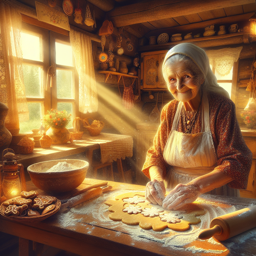

{
    'character_appearence': 'A gingerbread man with bright bead-like eyes and a wide smile, running joyfully.',
    'style_attributes': 'Photo-realistic with vibrant and lively colors.',
    'worn_and_carried': 'The gingerbread man has white icing features and a cheeky appearance.',
    'scenario': 'The gingerbread man running through a colorful meadow, followed by an old woman, cow, and horse.'
}

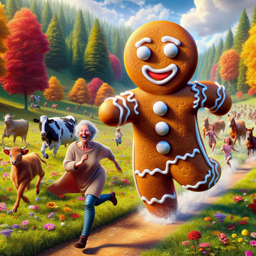

{
    'character_appearence': 'A sly fox with cunning eyes, engaging with the gingerbread man.',
    'style_attributes': 'Photo-realistic with a focus on sly and clever features.',
    'worn_and_carried': 'The fox has sharp features and a lolled tail.',
    'scenario': 'The gingerbread man on a wooden bridge, facing a sly fox by a sparkling river under sunlight.'
}

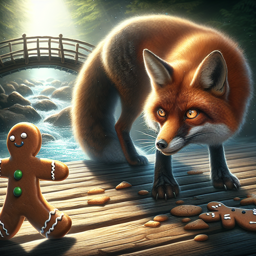

Writer:

Certainly! Here’s the final version of the short story with the enhanced illustrations for "The Escape of the      
Gingerbread Man."                                                                                                  

Title: The Escape of the Gingerbread Man                                                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 1: A Rustic Kitchen Scene In a quaint little cottage at the edge of an enchanted forest, an elderly   
woman, with flour-dusted hands, carefully shapes gingerbread dough on a wooden counter. The aroma of ginger,       
cinnamon, and cloves wafts through the air as a warm breeze from the open window dances with fluttering curtains.  
The sunlight gently permeates the cozy kitchen, casting a golden hue over the flour-dusted surfaces and the rolling
pin. Heartfelt trinkets and rustic decorations adorn the shelves—a sign of a lived-in, lovingly nurtured home.     

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Story:                                                                                                             

Once there was an old woman who lived alone in a charming cottage, her days filled with the joyful art of baking.  
One sunny afternoon, she decided to make a special gingerbread man to keep her company. As she shaped him tenderly 
and placed him in the oven, she couldn't help but smile at the delight he might bring.                             

But to her astonishment, once she opened the oven door to check on her creation, the gingerbread man leapt out,    
suddenly alive. His eyes were bright as beads, and his smile cheeky and wide. "Run, run, as fast as you can! You   
can't catch me, I'm the Gingerbread Man!" he laughed, darting towards the door.                                    

The old woman, chuckling at the unexpected mischief, gave chase, but her footsteps were slow with the weight of    
age. The Gingerbread Man raced out of the door and into the sunny afternoon.                                       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 2: A Frolic Through the Meadow The Gingerbread Man darts through a vibrant meadow, his arms swinging  
joyously by his sides. Behind him trails the old woman, her apron flapping in the wind as she gently tries to catch
up. Wildflowers of every color bloom vividly under the radiant sky, painting the scene with shades of nature's     
brilliance. Birds flit through the sky and a stream babbles nearby, oblivious to the chase taking place below.     

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Continuing his sprint, the Gingerbread Man encountered a cow grazing peacefully. Intrigued, the cow trotted        
forward. "Stop, Gingerbread Man! I wish to eat you!" she called, but the Gingerbread Man only twirled in a teasing 
jig, flashing his icing smile before darting off again.                                                            

"Run, run, as fast as you can! You can't catch me, I'm the Gingerbread Man!" he taunted, leaving the cow in his    
spicy wake.                                                                                                        

As he zoomed across the meadow, he spied a cautious horse in a nearby paddock, who neighed, "Oh! You look          
delicious! I want to eat you!" But the Gingerbread Man only laughed, his feet barely touching the earth. The horse 
joined the trail, hooves pounding, but even he couldn't match the Gingerbread Man's pace.                          

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Illustration 3: A Bridge Over a Sparkling Riv

User:                                                       

approve

In [10]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(
            content="Please write a short story about the gingerbread man with up to 3 photo-realistic illustrations.",
            source="User",
        )
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()

From the output, you can see the writer, illustrator, and editor agents
taking turns to speak and collaborate to generate a picture book, before
asking for final approval from the user.

## Next Steps

This example showcases a simple implementation of the group chat pattern -- 
**it is not meant to be used in real applications.** You can improve the
speaker selection algorithm. For example, you can avoid using LLM when simple
rules are sufficient and more reliable: 
you can use a rule that the editor always speaks after the writer.

The [AgentChat API](../../agentchat-user-guide/index.md) provides a high-level
API for selector group chat. It has more features but mostly shares the same
design as this implementation.